In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
# 像之前那样生成一些数据
# 为了使过拟合的效果更加明显，我们可以将问题的维数增加到200，并使用一个只包含20个样本的小训练集。
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [5]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [6]:
# 定义l2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [27]:
# 定义训练代码的实现
def train(lambd):
    w, b = init_params()
    # 延用之前的线性网络结构和损失函数
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    # item()的作用是取出单元素张量的元素值并返回该值，保持该元素类型不变。使用item()函数取出的元素值的精度更高
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 4.365906238555908


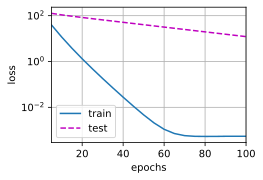

In [28]:
train(lambd=1)
# 可以通过增加lamda来防止过拟合

### 由上图可以看出，过拟合很明显

In [22]:
"""
由于权重衰减在神经网络优化中很常用， 深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中，以便与任何损失函数结合使用。 此外，这种集成还有计算上的好处， 允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。 由于更新的权重衰减部分仅依赖于每个参数的当前值， 因此优化器必须至少接触每个参数一次。
在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。 默认情况下，PyTorch同时衰减权重和偏移。 这里我们只为权重设置了weight_decay，所以偏置参数不会衰减。
"""
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    # 初始化参数（按照正态分布进行初始化）
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # wd就是正则化系数lamda
    # 我们只对权重w进行衰减，不对偏置b衰减（没必要），所以bias不需要加入weight_decay选项
    trainer = torch.optim.SGD([{"params":net[0].weight, 'weight_decay':wd},{"params":net[0].bias}], lr=lr)

    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
        print('w的L2范数：',net[0].weight.norm().item())

w的L2范数： 0.4498441219329834


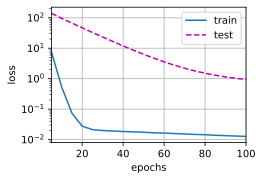

In [23]:
train_concise(3)